```{index} single: application; seating allocation
```
```{index} single: solver; cbc
```
```{index} single: Pyomo; parameters
```
```{index} single: Pyomo; sets
```
```{index} network optimization
```
```{index} max flow problem
```
```{index} networkx
```
```{index} feasibility problem
```

# Dinner seating arrangement

## Preamble: Install Pyomo and a solver

This cell selects and verifies a global SOLVER for the notebook.

If run on Google Colab, the cell installs Pyomo and HiGHS, then sets SOLVER to 
use the Highs solver via the appsi module. If run elsewhere, it assumes Pyomo and CBC
have been previously installed and sets SOLVER to use the CBC solver via the Pyomo 
SolverFactory. It then verifies that SOLVER is available.

In [1]:
import sys
 
if 'google.colab' in sys.modules:
    !pip install pyomo >/dev/null 2>/dev/null
    !pip install highspy >/dev/null 2>/dev/null
 
solver = 'appsi_highs'
 
import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)
 
assert SOLVER.available(), f"Solver {solver} is not available."

## Problem description

Assume that we are organizing a wedding dinner and our goal is to have guests from different families mingle with each other as much as possible. One way to do this is to seat people at tables so that no more people than a given threshold $k_{\max}$ from the same family sit at the same table. How could we solve a problem like this? 

First, we need the problem data. For each family $f \in F$ we need to know the number of its members $m_f$, and for each table $t \in T$ we need to know its capacity $c_t$. Using these data and the tools we have learned so far, we can formulate this problem as a LO problem.

If we are not concerned about specific individuals, but only about the number of people in a given family, then we can use variable $x_{ft}$ to determine the number of people in family $f$ who will sit at table $t$. In the problem formulation, we were not given any objective function, since our goal is to find a feasible seating arrangement. For this reason, we can set the objective function to a constant value, say $0$, and, in this way, do not differentiate between the various feasible solutions. 

The mathematical formulation of this seating allocation problem is:

$$
\begin{align*}
    \min \quad & 0\\
    \text{s.t.} \quad & \sum\limits_{f} x_{ft} \leq c_t && \forall \, t \in T \\
    & \sum\limits_{t} x_{ft} = m_f && \forall \, f \in F \\
    & 0 \leq x_{ft} \leq k_{\max}.
\end{align*}
$$

The constraints ensure that the seating capacity for each table is not exceeded, that each family is fully seated, and that the number of elements of each family at each table does not exceed the threshold $k$.

## Implementation

The problem statement will be satisfied by finding a feasible solution, if one exists. Because no specific objective has been specified, the mathematical formulation uses a constant 0 as essentially a placeholder for the objective function. Some optimization solvers, however, issue warning messages if they detect a constant objective, and others will fail to execute at all. A simple work around for these cases is to replace the constant objective with a 'dummy' variable that doesn't  appear elsewhere in the optimization problem. 

In [2]:
import pyomo.environ as pyo
from IPython.display import display
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def seat_allocation(members, capacity, kmax, domain=pyo.NonNegativeReals):
    m = pyo.ConcreteModel("Seating arrangement")

    m.F = pyo.Set(initialize=range(len(members)))
    m.T = pyo.Set(initialize=range(len(capacity)))

    m.M = pyo.Param(m.F, initialize=members)
    m.C = pyo.Param(m.T, initialize=capacity)

    m.x = pyo.Var(m.F, m.T, bounds=(0, kmax), domain=domain)
    m.dummy = pyo.Var(bounds=(0, 1), initialize=0)

    @m.Objective(sense=pyo.minimize)
    def goal(m):
        return m.dummy

    @m.Constraint(m.T)
    def capacity(m, t):
        return pyo.quicksum(m.x[f, t] for f in m.F) <= m.C[t]

    @m.Constraint(m.F)
    def seat(m, f):
        return pyo.quicksum(m.x[f, t] for t in m.T) == m.M[f]

    results = SOLVER.solve(m)

    return results, m


def get_solution(model):
    df = pd.DataFrame()
    for idx, x in model.x.items():
        f, t = idx
        df.loc[f, t] = x()
    df.index.name = "family"
    df.columns = [f"table {i}" for i in model.T]
    return df.round(5)


def report(model, results, type=int, verbose=False):
    if verbose:
        print(f"Solver status: {results.solver.status}")
        print(f"Termination condition: {results.solver.termination_condition}")
    if results.solver.termination_condition == "optimal":
        soln = get_solution(model).astype(type)
        display(soln)
        print(f"objective:       {pyo.value(model.goal)}")
        print(f"places at table: {list(soln.sum(axis=0).round(1))}")
        print(f"members seated:  {list(soln.sum(axis=1).round(1))}")

Let us now consider and solve a specific instance of this problem with six families with sizes $m = (6, 8, 2, 9, 13, 1)$, five tables with capacities $c = (8, 8, 10, 4, 9)$, and a threshold $k=3$ for the number of members of each family that can be seated at the same table. 

In [3]:
results, seatplan = seat_allocation(
    members=[6, 8, 2, 9, 13, 1], capacity=[8, 8, 10, 4, 9], kmax=3
)
report(seatplan, results, type=float)

,table 0,table 1,table 2,table 3,table 4
family,,,,,
0,0.0,1.0,2.0,0.0,3.0
1,3.0,0.0,2.0,0.0,3.0
2,0.0,0.0,0.0,2.0,0.0
3,2.0,3.0,3.0,0.0,1.0
4,3.0,3.0,3.0,2.0,2.0
5,0.0,1.0,0.0,0.0,0.0


objective:       0.0
places at table: [8.0, 8.0, 10.0, 4.0, 9.0]
members seated:  [6.0, 8.0, 2.0, 9.0, 13.0, 1.0]


A peculiar fact is that although we did not explicitly require that all variables $x_{ft}$ be integer, the optimal solution turned out to be integer anyway. This is no coincidence as it follows from a certain property of the problem we solve. This also means we can solve  larger versions of this problem with LO instead of MILO solvers to find integer solutions, gaining a large computational advantage.

## Minimize the maximum group size

Our objective was that we make members of different families mingle as much as possible. Is $k_{\max} = 3$ the lowest possible number for which a feasible table allocation exists or can we make the tables even more diverse by bringing this number down?

In order to find out, we can make $k=k_{\max}$ a decision variable and change the objective function as to minimize $k$, obtaining the following problem:

$$
\begin{align*}
    \min \quad & k \\
    \text{s.t.} \quad & \sum_{f} x_{ft} \leq c_t && \forall \, t \in T \nonumber \\
    & \sum_{t} x_{ft} = m_f && \forall \, f \in F \nonumber \\
    & 0 \leq x_{ft} \leq k  && \forall f \in F, t \in T \nonumber \\
    & k \geq 0. \nonumber
\end{align*}
$$

In [4]:
def seat_allocation_minimize_group_size(members, capacity, domain=pyo.NonNegativeReals):
    m = pyo.ConcreteModel("Seating arrangement minimizing the maximum group size")

    m.F = pyo.Set(initialize=range(len(members)))
    m.T = pyo.Set(initialize=range(len(capacity)))

    m.M = pyo.Param(m.F, initialize=members)
    m.C = pyo.Param(m.T, initialize=capacity)

    m.x = pyo.Var(m.F, m.T, domain=domain)
    m.k = pyo.Var(domain=domain)

    @m.Objective(sense=pyo.minimize)
    def goal(m):
        return m.k

    @m.Constraint(m.T)
    def capacity(m, t):
        return pyo.quicksum(m.x[f, t] for f in m.F) <= m.C[t]

    @m.Constraint(m.F)
    def seat(m, f):
        return pyo.quicksum(m.x[f, t] for t in m.T) == m.M[f]

    @m.Constraint(m.F, m.T)
    def bound(m, f, t):
        return m.x[f, t] <= m.k

    results = SOLVER.solve(m)

    return results, m

We now solve the same instance as before.

In [5]:
results, seatplan = seat_allocation_minimize_group_size(
    members=[6, 8, 2, 9, 13, 1], capacity=[8, 8, 10, 4, 9], domain=pyo.NonNegativeReals
)
report(seatplan, results, type=float)

,table 0,table 1,table 2,table 3,table 4
family,,,,,
0,2.6,0.0,2.2,0.0,1.2
1,0.2,1.8,2.6,1.4,2.0
2,0.0,0.0,0.0,0.0,2.0
3,2.6,2.6,2.6,0.0,1.2
4,2.6,2.6,2.6,2.6,2.6
5,0.0,1.0,0.0,0.0,0.0


objective:       2.6
places at table: [8.0, 8.0, 10.0, 4.0, 9.0]
members seated:  [6.0, 8.0, 2.0, 9.0, 13.0, 1.0]


Unfortunately, this solution is no longer integer. Mathematically, this is because the "structure" that previously ensured integer solutions at no extra cost has been lost as a result of making $k$ a decision variable. To find the solution to this problem we need to impose that the variables are integers.

Using an MILO solver such as `cbc` or `highs` and specifying the desired domain for the variables using `domain=pyo.NonNegativeIntegers`, we can recover the original optimal value $k = 3$.

In [6]:
results, seatplan = seat_allocation_minimize_group_size(
    members=[6, 8, 2, 9, 13, 1],
    capacity=[8, 8, 10, 4, 9],
    domain=pyo.NonNegativeIntegers,
)
report(seatplan, results, type=int)

,table 0,table 1,table 2,table 3,table 4
family,,,,,
0,3,0,2,0,1
1,0,3,3,1,1
2,0,0,0,0,2
3,2,3,2,0,2
4,3,1,3,3,3
5,0,1,0,0,0


objective:       3.0
places at table: [8, 8, 10, 4, 9]
members seated:  [6, 8, 2, 9, 13, 1]


## Minimize number of tables

Let us fix again to $k_{\max} = 3$ the maximum number of family members that can be seated at the same table and focus on minimizing the number of tables used. Let us introduce a binary variable $y_t$ that is equal to 1 if table $t$ is used and 0 otherwise. We can thus consider a new optimization problem in which we minimize the sum of $y_t$ over $t=1,\ldots,T$. The mathematical formulation of this new problem is:

$$
\begin{align*}
    \min \quad & \sum_{t} y_t\\
    \text{s.t.} \quad & \sum\limits_{f} x_{ft} \leq c_t \cdot y_t && \forall \, t \in T \\
    & \sum\limits_{t} x_{ft} = m_f && \forall \, f \in F \\
    & 0 \leq x_{ft} \leq k_{\max}.
\end{align*}
$$

We can implement it in Pyomo as follows.

In [7]:
def seat_allocation_minimize_tables(
    members, capacity, kmax, domain=pyo.NonNegativeReals
):
    m = pyo.ConcreteModel("Seating arrangement minimizing the number of tables")
    m.F = pyo.Set(initialize=range(len(members)))
    m.T = pyo.Set(initialize=range(len(capacity)))
    m.M = pyo.Param(m.F, initialize=members)
    m.C = pyo.Param(m.T, initialize=capacity)
    m.x = pyo.Var(m.F, m.T, bounds=(0, kmax), domain=domain)
    m.y = pyo.Var(m.T, domain=pyo.Binary)

    @m.Objective(sense=pyo.minimize)
    def goal(m):
        return pyo.quicksum(m.y[t] for t in m.T)

    @m.Constraint(m.T)
    def capacity(m, t):
        return pyo.quicksum(m.x[f, t] for f in m.F) <= m.C[t] * m.y[t]

    @m.Constraint(m.F)
    def seat(m, f):
        return pyo.quicksum(m.x[f, t] for t in m.T) == m.M[f]

    results = SOLVER.solve(m)

    return results, m

In [8]:
results, seatplan = seat_allocation_minimize_tables(
    members=[6, 8, 2, 9, 13, 1],
    capacity=[8, 8, 10, 4, 9],
    kmax=3,
    domain=pyo.NonNegativeIntegers,
)
report(seatplan, results, type=int)

,table 0,table 1,table 2,table 3,table 4
family,,,,,
0,0,2,1,0,3
1,0,1,3,1,3
2,2,0,0,0,0
3,3,3,3,0,0
4,3,1,3,3,3
5,0,1,0,0,0


objective:       5.0
places at table: [8, 8, 10, 4, 9]
members seated:  [6, 8, 2, 9, 13, 1]


# Reformulation as max flow problem

However, using an MILO solver is not necessarily the best approach for problems like this. Many real-life situations (e.g., assigning people to groups/teams) require solving really large problems. There are existing algorithms that can leverage the special **network structure** of the problem at hand and scale better than LO solvers. 

To illustrate this, we first visualize the seating problem using a graph where:
* the nodes on the left-hand side stand for the families and the numbers next to them provide the family size;
* the nodes on the left-hand side stand for the tables and the numbers next to them provide the table size;
* each left-to-right arrow stand comes with a number denoting the capacity of arc $(f, t)$ -- how many people of family $f$ can be assigned to table $t$.

![](seating_model_basic.png)

If we think of each family as a "supply of individuals" and each table as a "demand of individuals", then we can rephrase our original task as the problem of sending people from families $f$ to tables $t$ so that everyone is assigned to some table, the tables' capacities are respected, and no table gets more than $k_{\max} = 3$ members of the same family.

$$
\begin{align*}
    \min \quad & \sum_{t, f} x_{ft}\\
    \text{s.t.} \quad & \sum\limits_{f} x_{ft} \leq c_t && \forall \, t \in T \\
    & \sum\limits_{t} x_{ft} = m_f && \forall \, f \in F \\
    & 0 \leq x_{ft} \leq k_{\max}.
\end{align*}
$$


A Pyomo version of this model is given in the next cell. After that we will show how to reformulate the calculation using network algorithms.

In [9]:
def seating_allocation_maximize_flow_to_tables(
    members, capacity, kmax, domain=pyo.NonNegativeReals
):
    m = pyo.ConcreteModel("Seating arrangement as network problem")
    m.F = pyo.Set(initialize=range(len(members)))
    m.T = pyo.Set(initialize=range(len(capacity)))
    m.M = pyo.Param(m.F, initialize=members)
    m.C = pyo.Param(m.T, initialize=capacity)
    m.x = pyo.Var(m.F, m.T, bounds=(0, kmax), domain=domain)

    @m.Objective(sense=pyo.maximize)
    def goal(m):
        return pyo.quicksum(m.x[f, t] for f in m.F for t in m.T)

    @m.Constraint(m.T)
    def capacity(m, t):
        return pyo.quicksum(m.x[f, t] for f in m.F) <= m.C[t]

    @m.Constraint(m.F)
    def seat(m, f):
        return pyo.quicksum(m.x[f, t] for t in m.T) == m.M[f]

    results = SOLVER.solve(m)

    return results, m


results, seatplan = seating_allocation_maximize_flow_to_tables(
    members=[6, 8, 2, 9, 13, 1],
    capacity=[8, 8, 10, 4, 9],
    kmax=3,
    domain=pyo.NonNegativeIntegers,
)

report(seatplan, results, type=int)

,table 0,table 1,table 2,table 3,table 4
family,,,,,
0,0,3,0,0,3
1,1,1,3,0,3
2,0,0,2,0,0
3,3,3,2,1,0
4,3,1,3,3,3
5,1,0,0,0,0


objective:       39.0
places at table: [8, 8, 10, 4, 9]
members seated:  [6, 8, 2, 9, 13, 1]


By adding two more nodes to the graph above, we can formulate the problem as a slightly different flow problem where all the data is formulated as the arc capacity, see figure below. In a network like this, we can imagine a problem of sending resources from the _source node_ "door" to the _target node_ "seat", subject to the restriction that for any node that is neither the source nor the target, the sum of incoming and outgoing flows are equal (_balance constraint_). If there exists a flow in this new graph that respects the arc capacities and the sum of outgoing flows at the source is equal to the total number of individuals, that is $\sum_{f \in F} m_f$, it means that there exists a family-to-table assignment that meets our requirements.

![](seating_flow_model.png)

Thus, if we maximize the total flow going out of `door` and reaching `seat` and it matches the total number of individuals, the problem is solved. As unimpressive as this sounds, this means that it can be treated as a special case of a famous **maximum flow problem**, for which there exist algorithms that are way more efficient than a generic LO solver. One such algorithm is the Bellman-Ford algorithm, implicitly invoked in the following code using the Python package `networkx`.

In [10]:
def model_as_network(members, capacity, kmax):
    # create lists of families and tables
    families = [f"f{i}" for i in range(len(members))]
    tables = [f"t{j}" for j in range(len(capacity))]

    # create digraphy object
    G = nx.DiGraph()

    # add edges
    G.add_edges_from(["door", f, {"capacity": n}] for f, n in zip(families, members))
    G.add_edges_from([(f, t) for f in families for t in tables], capacity=kmax)
    G.add_edges_from([t, "seat", {"capacity": n}] for t, n in zip(tables, capacity))

    return G


members = [6, 8, 2, 9, 13, 1]
capacity = [8, 8, 10, 4, 9]
G = model_as_network(members, capacity, kmax=3)

# we solve the maximum flow problem using the networkx function
flow_value, flow_dict = nx.maximum_flow(G, "door", "seat")

# we parse and table the solution
families = [f"f{i}" for i in range(len(members))]
tables = [f"t{j}" for j in range(len(capacity))]
pd.DataFrame(flow_dict).loc[tables, families].astype("int")

,f0,f1,f2,f3,f4,f5
t0,3,0,0,1,3,1
t1,0,2,0,3,3,0
t2,0,3,1,3,3,0
t3,0,1,0,0,3,0
t4,3,2,1,2,1,0


Even for this very small example, we see that network algorithms generate a solution significantly faster than using the MILO formulation above. Realizing that the optimization problem we are tackling is a particular problem class for which a tailored algorithm is available can result in solving times orders of magnitude faster, particularly for large instances.

In [11]:
%time flow_value, flow_dict = nx.maximum_flow(G, 'door', 'seat')

%time results, seatplan = seating_allocation_maximize_flow_to_tables(members=[6, 8, 2, 9, 13, 1], capacity=[8, 8, 10, 4, 9], kmax=3, domain=pyo.NonNegativeIntegers)

CPU times: user 405 µs, sys: 8 µs, total: 413 µs
Wall time: 414 µs
CPU times: user 3.9 ms, sys: 5.22 ms, total: 9.13 ms
Wall time: 16.3 ms


## A more systematic comparison between LO solvers and network algorithms

We now create increasingly larger instances of the dinner seating allocation problem and compare the performance of the MILO solvers `highs`, `cbc`, `gurobi`, and the algorithm `maximum_flow` from the `networkx` library. We will use the following code to generate the instances.

In [ ]:
from tqdm.notebook import tqdm
from time import perf_counter as pc


def max_flow(members, capacity, kmax, domain=pyo.NonNegativeReals):
    m = pyo.ConcreteModel("Seating arrangement as network problem")
    m.F = pyo.Set(initialize=range(len(members)))
    m.T = pyo.Set(initialize=range(len(capacity)))
    m.M = pyo.Param(m.F, initialize=members)
    m.C = pyo.Param(m.T, initialize=capacity)
    m.x = pyo.Var(m.F, m.T, bounds=(0, kmax), domain=domain)

    @m.Objective(sense=pyo.maximize)
    def goal(m):
        return pyo.quicksum(m.x[f, t] for f in m.F for t in m.T)

    @m.Constraint(m.T)
    def capacity(m, t):
        return pyo.quicksum(m.x[f, t] for f in m.F) <= m.C[t]

    @m.Constraint(m.F)
    def seat(m, f):
        return pyo.quicksum(m.x[f, t] for t in m.T) == m.M[f]

    return m


cbc = pyo.SolverFactory("cbc")
gurobi = pyo.SolverFactory("gurobi_direct")
highs = pyo.SolverFactory("appsi_highs")


def Reset(model) -> None:
    for v in model.component_data_objects(ctype=pyo.Var, descend_into=True):
        v.set_value(None)


np.random.seed(2023)
kmax = 3
nmax = 500
mmax = 2 * nmax
sizes = list(zip(range(10, nmax, 10), range(20, mmax, 20)))

df = pd.DataFrame(index=["cbc", "gurobi", "nx", "highs"], columns=sizes)
for n, m in tqdm(sizes):
    members, capacity = np.random.randint(1, 10, n), np.random.randint(3, 8, m)
    model = max_flow(members, capacity, kmax)
    t = pc()
    cbc.solve(model)
    df.loc["cbc"][(n, m)] = pc() - t
    Reset(model)
    t = pc()
    gurobi.solve(model)
    df.loc["gurobi"][(n, m)] = pc() - t
    t = pc()
    highs.solve(model)
    df.loc["highs"][(n, m)] = pc() - t
    Reset(model)
    G = model_as_network(members, capacity, kmax)
    t = pc()
    nx.maximum_flow(G, "door", "seat")
    df.loc["nx"][(n, m)] = pc() - t

We stored all the runtimes in a dataframe, which we can now plot. We see that the network algorithm `maximum_flow` is the fastest, followed by `highs`, `cbc`, and `gurobi`. The network algorithm is the fastest because it is able to exploit the special structure of the problem, which the MILO solvers do not.

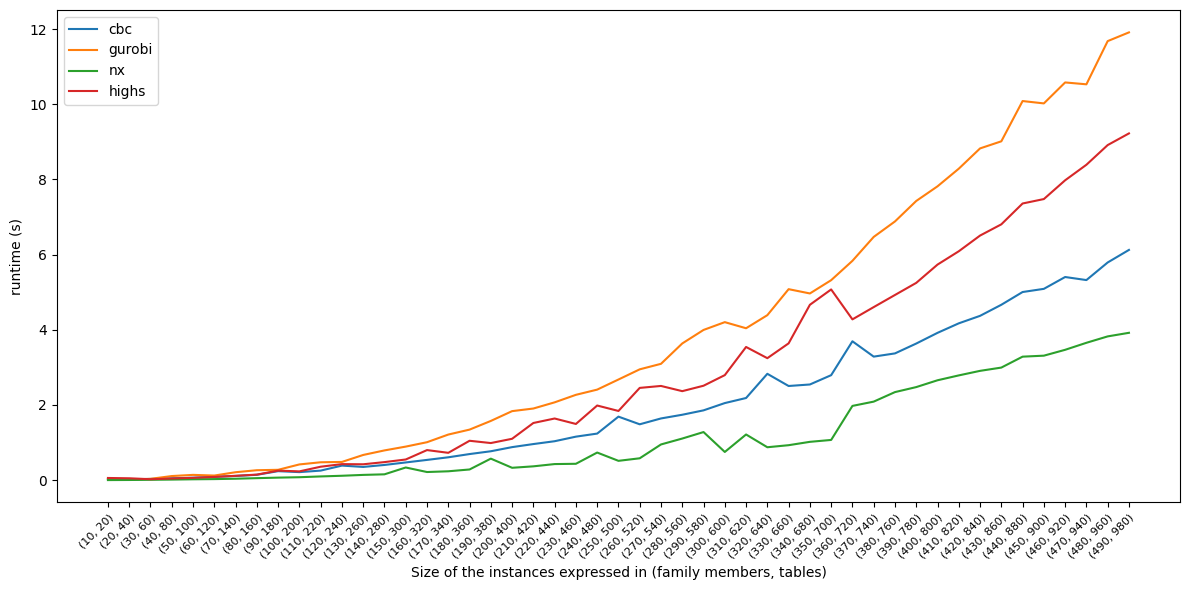

In [17]:
plt.rcParams["figure.figsize"] = [12, 6]
df.transpose().plot()
plt.ylabel("runtime (s)")
plt.xticks(
    range(len(df.columns)),
    df.columns,
    rotation=45,
    ha="right",
    fontsize=8,
    rotation_mode="anchor",
)
plt.xlabel("Size of the instances expressed in (family members, tables)")
plt.tight_layout()
plt.show()